Boilerplate code from this link (Amazing Resource) - https://nextjournal.com/gkoehler/pytorch-mnist


In [1]:
# !pip install torch torchvision
# !pip install -r requirements.txt

In [2]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary


#### Define parameters

In [3]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 200

random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

#### Initialize PyTorch Dataset and Dataloader, Make use of torchvision MNIST API

In [4]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

#### Take out an example set for future use

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [6]:
example_data.shape

torch.Size([1000, 1, 28, 28])

#### View the sampes from example data


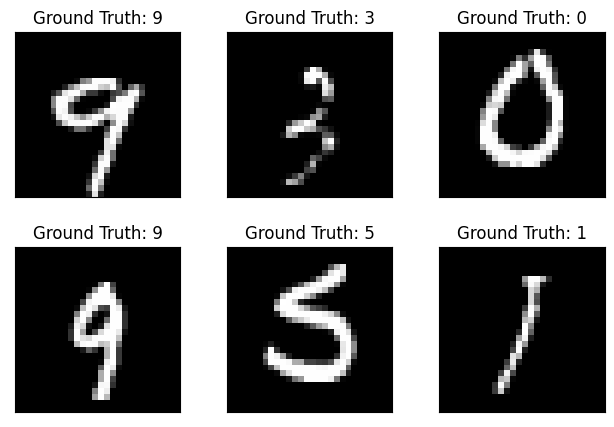

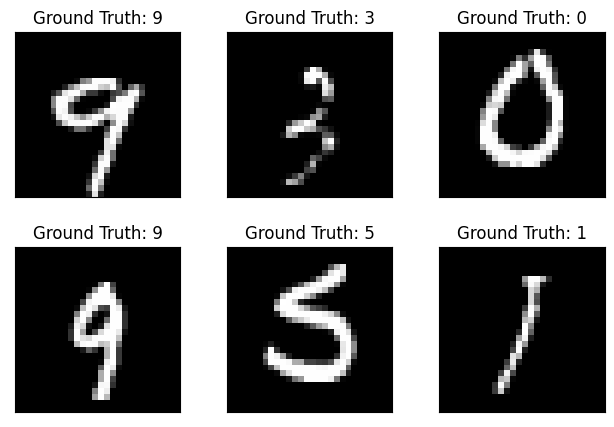

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

#### Functions to encode and decode binary and decimal. Used to treat input/outputs of the network

In [8]:
import math

In [9]:
def encodeDecimalToBinary(n, n_classes):
    binary = bin(n).replace("0b", "")
    bin_val = str('0'*(n_classes - len(binary))) + str(binary)
    res = [int(x) for x in str(bin_val)]
    return res

In [10]:
encodeDecimalToBinary(16, 5)

[1, 0, 0, 0, 0]

In [11]:
def decodeGetPrediction(pred):
    # First 4 bits -> MNIST digit
    # Last 5 bits -> SUM part
    _mnist = int(''.join(map(str, pred[:4].int().tolist())), 2)
    _sum = int(''.join(map(str, pred[4:].int().tolist())), 2)
    return {"MNIST Class": _mnist, "Sum": _sum}

#### Random Batch Sampler (Used to synthesize the training set required as a 2nd input to network)

In [12]:
class RandomSampler:
    def __init__(self, bs=32):
        self.bs = bs
    
    def getRandomBatch(self, n_classes):
        label = torch.randint(0, 10, (self.bs,))
        binaryList = []
        for el in label:
            binaryList.append(encodeDecimalToBinary(el, n_classes))
        X = torch.tensor(binaryList)
        
        return X, label

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(324, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 9)

    def forward(self, x, x_rand):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = torch.cat((x, x_rand), 1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.sigmoid(x) # F.log_softmax(x)
    
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net()
model.to(device)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=324, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=9, bias=True)
)

In [14]:
# test model with sample datapoints, 2 batch size.
# multiple inputs to forward pass of the network

model(torch.rand(2, 1, 28, 28).to(device), torch.rand(2, 4).to(device))

tensor([[0.5417, 0.5200, 0.5172, 0.4777, 0.4774, 0.5007, 0.5307, 0.4910, 0.5259],
        [0.5368, 0.5030, 0.5243, 0.4842, 0.4870, 0.5093, 0.5341, 0.4743, 0.5137]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)

In [15]:
# Initialize the model and use Adam Optimizer
network = Net()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [16]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

#### Define utility function to convert batch of data (I agree, it's not optimal!)

In [17]:
def convertBatchDecimalToBinary(t, n_classes):
    binaryList = []
    for el in t:
        binaryList.append(encodeDecimalToBinary(el, n_classes))
    return torch.tensor(binaryList, dtype=torch.float32)

def getSumBinaryRepr(target1, target2, n_classes):
    total_sum = target1 + target2
    binaryList = []
    for el in total_sum:
        binaryList.append(encodeDecimalToBinary(el, n_classes))
    return torch.tensor(binaryList, dtype=torch.float32)
    

#### Training Loop

In [18]:
def train(epoch):
    network.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()

        # Get Random samples, batch size matches with the train_dataloader size
        rs = RandomSampler(len(data))
        X_rand, label_rand = rs.getRandomBatch(4) # Input
        
        # Pass both the inputs, (mnist, random data) to the neural network
        output = network(data, X_rand)
        
        # Train target consolidation to manage the binary encodings
        bin_target = convertBatchDecimalToBinary(target, 4)
        bin_sum = getSumBinaryRepr(label_rand, target, 5)
        bin_true_targets = torch.cat((bin_target, bin_sum), 1)
        
        # Binary cross entropy loss, its a multi-label classification.
        # Unnormalized output, it doesnt sum upto 1.
        loss = F.binary_cross_entropy(output, bin_true_targets)
        
        loss.backward()
        optimizer.step()
                        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))


#### Testing Loop

In [19]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
                    
            rs = RandomSampler(len(data))
            X_rand, label_rand = rs.getRandomBatch(4) # Input
            bin_y_rand = X_rand

            output = network(data, X_rand)
            
            bin_target = convertBatchDecimalToBinary(target, 4)
            bin_sum = getSumBinaryRepr(label_rand, target, 5)
            bin_true_targets = torch.cat((bin_target, bin_sum), 1)
            
            test_loss += F.binary_cross_entropy(output, bin_true_targets).item()
            
            pred = np.round(output)
            correct += torch.sum((pred.eq(bin_true_targets)).all(dim=1))
                        
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [20]:
# Run it for n number of epochs

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: 0.0007, Accuracy: 0/10000 (0%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.704001
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.419572
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.364976
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.362401
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.309268

Test set: Avg. loss: 0.0002, Accuracy: 3690/10000 (37%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.306592
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.345291
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.274710
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.253348
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.189360

Test set: Avg. loss: 0.0001, Accuracy: 8321/10000 (83%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.170133
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.177237
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.149321
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.137563
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.219527

Test set: Avg. loss: 0.0001, Accuracy: 9292/10000 (93%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0

#### Plot Test Loss

Text(0, 0.5, 'Binary Cross Entropy Loss')

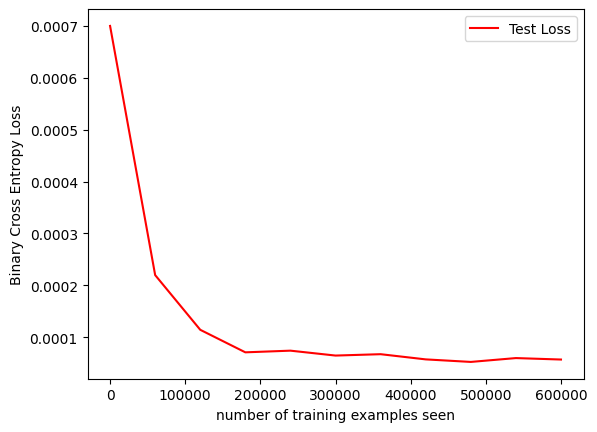

In [21]:
fig = plt.figure()
plt.plot(test_counter, test_losses, color='red')
plt.legend(['Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('Binary Cross Entropy Loss')


#### Plot Train Loss

Text(0, 0.5, 'Binary Cross Entropy Loss')

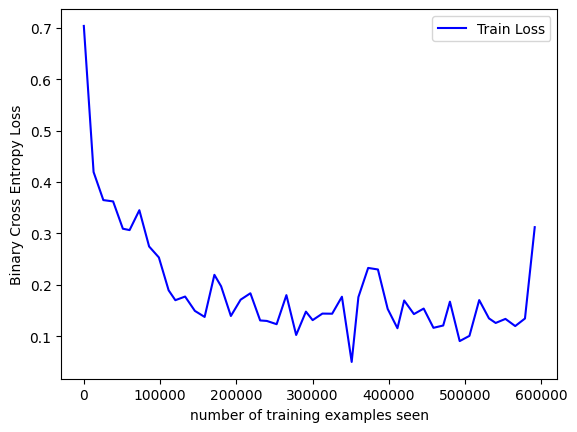

In [22]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('Binary Cross Entropy Loss')


#### Time for the good part!!! Visualize the inputs and predicted output.


Revisit our good old friend - example_data.

In [23]:
example_data.shape

torch.Size([1000, 1, 28, 28])

In [24]:
rs = RandomSampler(1000)
X_rand, label_rand = rs.getRandomBatch(4)
with torch.no_grad():
    output = network(example_data, X_rand)

In [25]:
def binToDec(t):
    return int(''.join(map(str, t.int().tolist())), 2)

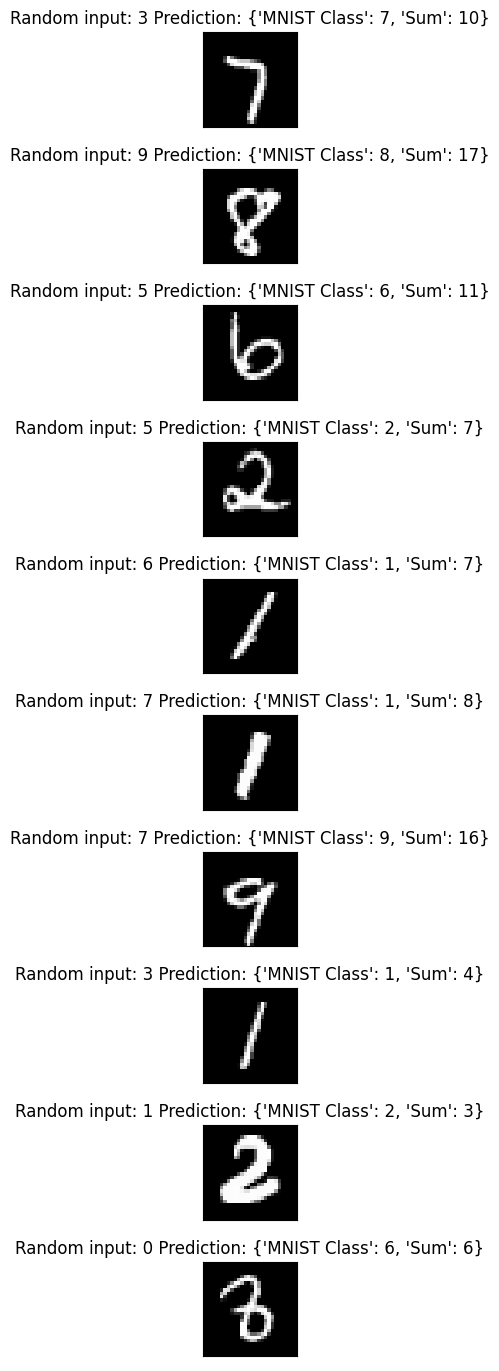

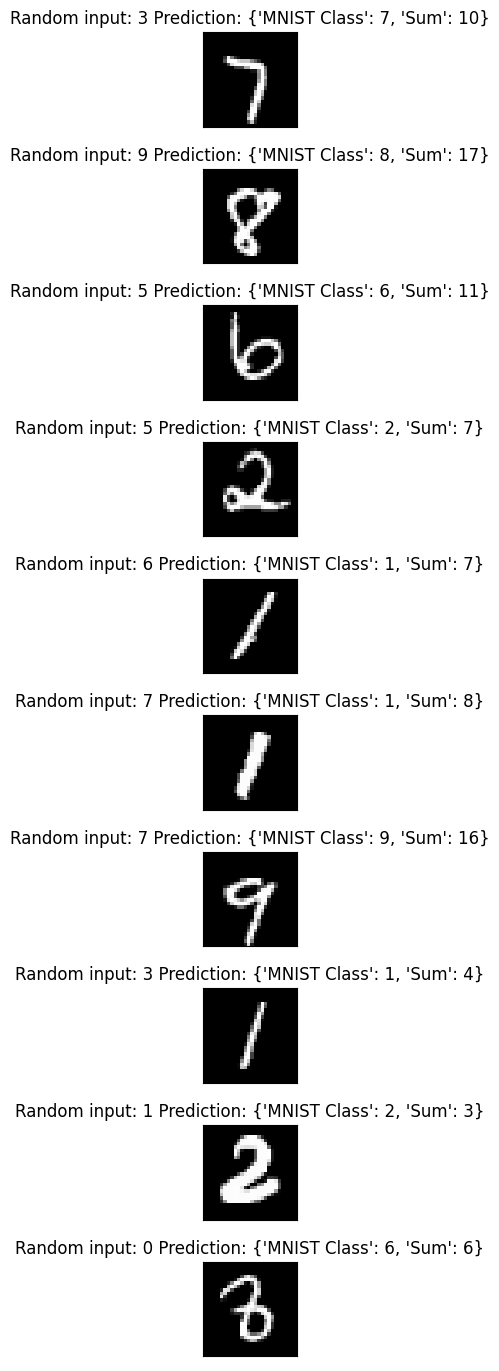

In [26]:
import random
ls = list(zip(example_data, output, X_rand))
random.shuffle(ls)

fig = plt.figure(figsize=(20, 14))
for idx, data in enumerate(ls):
    if idx > 9:
        break
    plt.subplot(10,1,idx+1)
    plt.tight_layout()
    plt.imshow(data[0][0], cmap='gray', interpolation='none')
    plt.title("Random input: {} Prediction: {}".format(
        binToDec(data[2]), decodeGetPrediction(np.round(data[1]))
    ))
    plt.xticks([])
    plt.yticks([])
    
fig